✅ Real-Time KPI Summary by Platform


platform,current_eng_rate,avg_success_prob,num_creators
youtube,0.0,0.04742587317756678,1
twitter,0.0,0.04742587317756678,1
tiktok,0.0,0.04742587317756678,1
instagram,0.0,0.04742587317756678,1


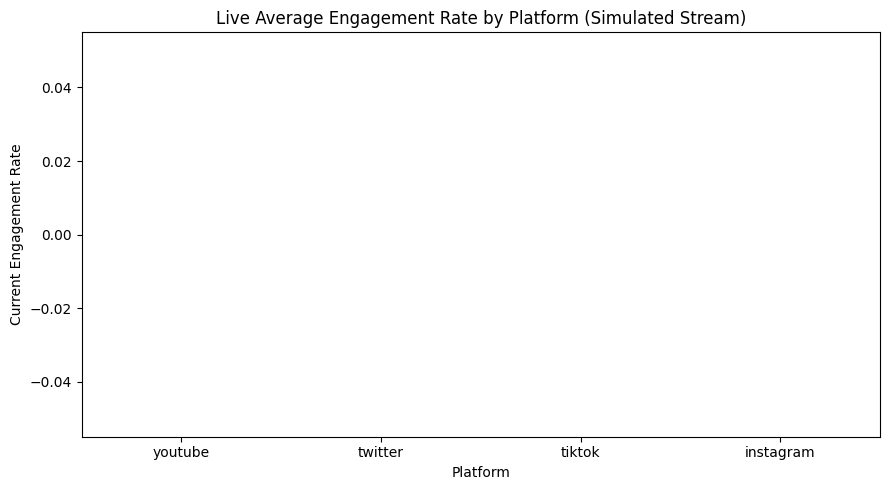

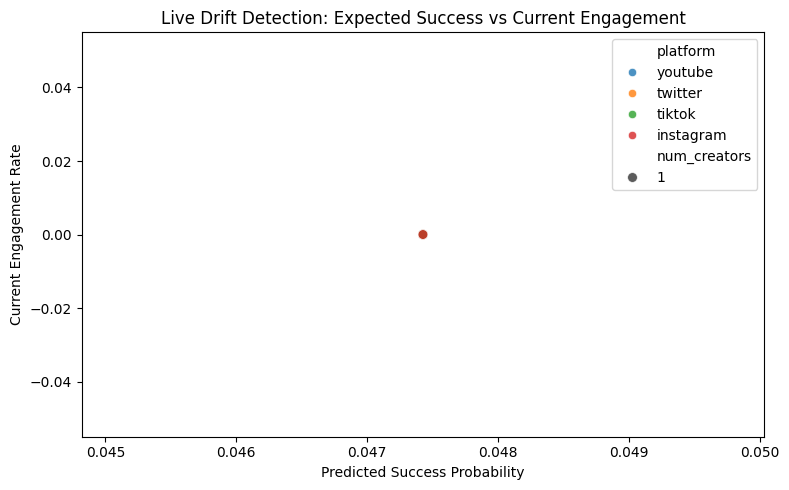

🚨 Real-Time Alerts Summary


platform,performance_flag,count
instagram,✅ Stable,1
tiktok,✅ Stable,1
twitter,✅ Stable,1
youtube,✅ Stable,1


/databricks/python/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/databricks/python/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


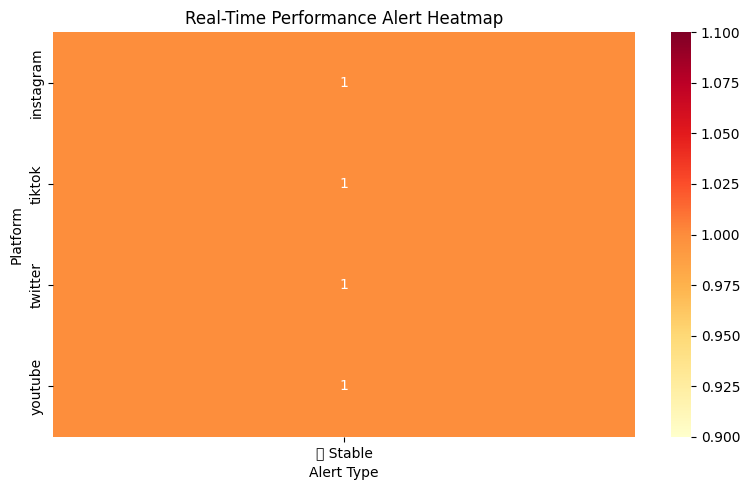

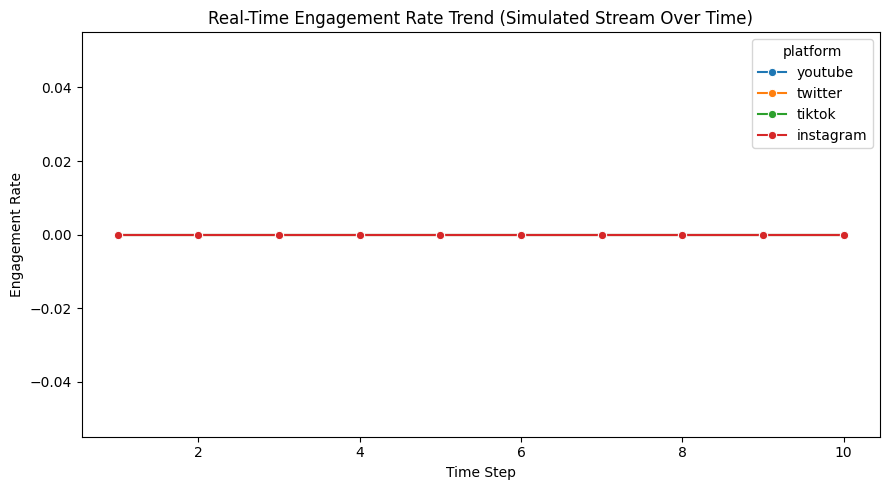

In [0]:
# MAGIC %run ./00_config
# STEP 6: Real-Time Monitoring & Alerts Layer (Streaming Simulation)

from pyspark.sql import functions as F
from pyspark.sql.types import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# ---- Safe fallback if 00_config not loaded ----
try:
    tbl  # type: ignore
except NameError:
    CATALOG = "influencer"
    def tbl(name: str) -> str:
        return f"{CATALOG}.{name}"

# ---- Load base data ----
pred_tbl = tbl("ml.creator_predictions")
features_tbl = tbl("ml.creator_features")

if not (spark.catalog.tableExists(pred_tbl) and spark.catalog.tableExists(features_tbl)):
    raise RuntimeError("❌ Required tables missing. Run Steps 3–5 first!")

preds = spark.table(pred_tbl)
features = spark.table(features_tbl)

# ---- Simulate streaming updates (mock real-time data ingestion) ----
# For live systems, this would come via Kafka or an API stream
stream_df = (
    features.join(preds, on="creator_norm_id", how="inner")
    .withColumn("timestamp", F.current_timestamp())
    .withColumn("recent_eng_rate", F.col("avg_eng_rate") * (1 + F.rand() * 0.3 - 0.15))  # simulate ±15% drift
)

# ---- Real-time KPI aggregation ----
agg_df = (
    stream_df.groupBy("platform")
    .agg(
        F.avg("recent_eng_rate").alias("current_eng_rate"),
        F.avg("success_prob").alias("avg_success_prob"),
        F.count("*").alias("num_creators")
    )
    .orderBy(F.desc("current_eng_rate"))
)

print("✅ Real-Time KPI Summary by Platform")
display(agg_df)

# ---- Convert to Pandas for visualization ----
pdf = agg_df.toPandas()

# ---------------------------------------------------------------------
# 1️⃣ Real-time KPI Bar Chart
# ---------------------------------------------------------------------
plt.figure(figsize=(9, 5))
sns.barplot(x="platform", y="current_eng_rate", data=pdf, hue="platform", dodge=False)
plt.title("Live Average Engagement Rate by Platform (Simulated Stream)")
plt.ylabel("Current Engagement Rate")
plt.xlabel("Platform")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# 2️⃣ Engagement Drift Monitoring – Predicted vs Actual
# ---------------------------------------------------------------------
plt.figure(figsize=(8, 5))
sns.scatterplot(
    x="avg_success_prob",
    y="current_eng_rate",
    data=pdf,
    hue="platform",
    size="num_creators",
    sizes=(50, 300),
    alpha=0.8,
)
plt.title("Live Drift Detection: Expected Success vs Current Engagement")
plt.xlabel("Predicted Success Probability")
plt.ylabel("Current Engagement Rate")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# 3️⃣ Anomaly Detection Logic – Alerts
# ---------------------------------------------------------------------
alerts = stream_df.withColumn(
    "performance_flag",
    F.when(F.col("recent_eng_rate") < F.col("avg_eng_rate") * 0.75, "⚠️ Drop Detected")
     .when(F.col("recent_eng_rate") > F.col("avg_eng_rate") * 1.25, "🚀 Spike Detected")
     .otherwise("✅ Stable")
)

alert_summary = alerts.groupBy("platform", "performance_flag").count().orderBy("platform")

print("🚨 Real-Time Alerts Summary")
display(alert_summary)

# ---- Convert to Pandas for alert visualization ----
alert_pdf = alert_summary.toPandas()

# ---------------------------------------------------------------------
# 4️⃣ Alert Distribution Heatmap
# ---------------------------------------------------------------------
alert_pivot = alert_pdf.pivot(index="platform", columns="performance_flag", values="count").fillna(0)
plt.figure(figsize=(8, 5))
sns.heatmap(alert_pivot, annot=True, cmap="YlOrRd", fmt=".0f")
plt.title("Real-Time Performance Alert Heatmap")
plt.xlabel("Alert Type")
plt.ylabel("Platform")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# 5️⃣ Time-based Engagement Monitoring (Simulated Stream Trend)
# ---------------------------------------------------------------------
# For a static demo, simulate time-based changes
trend_data = []
for t in range(1, 11):
    pdf["time"] = t
    pdf["simulated_eng_rate"] = pdf["current_eng_rate"] * (1 + (0.05 * (0.5 - (t % 2))))
    trend_data.append(pdf.copy())
trend_df = pd.concat(trend_data)

plt.figure(figsize=(9, 5))
sns.lineplot(data=trend_df, x="time", y="simulated_eng_rate", hue="platform", marker="o")
plt.title("Real-Time Engagement Rate Trend (Simulated Stream Over Time)")
plt.xlabel("Time Step")
plt.ylabel("Engagement Rate")
plt.tight_layout()
plt.show()
